## Assignment 3 - Transfer learning + CNN classification

Your .py script should minimally do the following:

-Load the CIFAR10 dataset

-Use VGG16 to perform feature extraction

-Train a classifier

-Save plots of the loss and accuracy

-Save the classification report

In [1]:
#packages
import os

# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
from tensorflow.keras.datasets import cifar10

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt

2022-04-24 15:18:52.885738: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-24 15:18:52.885770: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Loading CIFAR_10
#Printing to terminal
print("CIFAR_10 data is being loaded - Please Wait...")

(X_train, y_train), (X_test, y_test) = cifar10.load_data() #Splitting data up into train and test data. 

print("CIFAR_10 data has been loaded successfully")

CIFAR_10 data is being loaded - Please Wait...
170508288/170498071 [==============================] - 7s 0us/step
CIFAR_10 data has been loaded successfully


In [3]:
#normalize
X_train = X_train/255
X_test = X_test/255

In [4]:
#Binarize labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train) #fitting and transforing to data
y_test = lb.fit_transform(y_test)

#labels for CIFAR-10 dataset in alphabetical order
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [6]:
#Check tensor shape
print(X_train.shape) #correct shape: 50000 images, 32x32X3

(50000, 32, 32, 3)


In [7]:
# load and initilize VGG16
#Printing to terminal
print("model VGG16 is being loaded - Please Wait...")
model = VGG16(include_top = False, 
              pooling = "avg", #pooling layer
              input_shape = (32,32,3))#change input shape

model VGG16 is being loaded - Please Wait...


2022-04-24 15:19:27.302946: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-24 15:19:27.302990: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (j-66621-job-0): /proc/driver/nvidia/version does not exist
2022-04-24 15:19:27.303496: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


58900480/58889256 [==============================] - 1s 0us/step


In [8]:
#Disable training of Conv layers
#disable while training - stay intact during training or else no transfer learning. 
#if it updates it defeats the purpose
for layer in model.layers:
    layer.trainable = False

In [10]:
print(model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [11]:
#add new classification layers
flat1 = Flatten()(model.layers[-1].output) #flattening layer, output of the last layer of model
class1 = Dense(128, activation = "relu")(flat1)
output = Dense(10, activation = "softmax")(class1)

In [12]:
#adding everything together
model = Model(inputs = model.inputs, outputs = output)

In [13]:
#summarize
print(model.summary()) #new layers

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [14]:
#Compile
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, #start learning quickly
    decay_steps=10000, #go down 10000 (big steps)
    decay_rate=0.9) #take smaller steps with each epoch: slowing down

sgd = SGD(learning_rate= lr_schedule)

In [15]:
model.compile(optimizer=sgd,
              loss="categorical_crossentropy",
              metrics=["accuracy"]) #can change this (look it up)

In [16]:
#Train model
print("[INFO] training model...")
H = model.fit(X_train, y_train,
              validation_data = (X_test, y_test),
              batch_size = 128, #how many images we are looking at at a time
              epochs = 10,
              verbose = 1) #printed to the screen as it is training

[INFO] training model...
Epoch 1/10
391/391 [==============================] - 31s 79ms/step - loss: 2.0107 - accuracy: 0.2988 - val_loss: 1.8026 - val_accuracy: 0.3893
Epoch 2/10
391/391 [==============================] - 30s 76ms/step - loss: 1.7055 - accuracy: 0.4236 - val_loss: 1.6455 - val_accuracy: 0.4324
Epoch 3/10
391/391 [==============================] - 30s 77ms/step - loss: 1.5834 - accuracy: 0.4599 - val_loss: 1.5562 - val_accuracy: 0.4624
Epoch 4/10
391/391 [==============================] - 30s 77ms/step - loss: 1.5127 - accuracy: 0.4815 - val_loss: 1.5025 - val_accuracy: 0.4779
Epoch 5/10
391/391 [==============================] - 30s 76ms/step - loss: 1.4646 - accuracy: 0.4968 - val_loss: 1.4650 - val_accuracy: 0.4910
Epoch 6/10
391/391 [==============================] - 30s 77ms/step - loss: 1.4293 - accuracy: 0.5075 - val_loss: 1.4365 - val_accuracy: 0.4999
Epoch 7/10
391/391 [==============================] - 30s 76ms/step - loss: 1.4012 - accuracy: 0.5175 - val_los

In [17]:
# make path to output data
outpath = os.path.join("..","..","cds-visual","Assignments","output")

In [18]:
#evaluate
#Plotting function (from session_9)
def plot_history(H, epochs):
    plt.style.use("seaborn-colorblind")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()

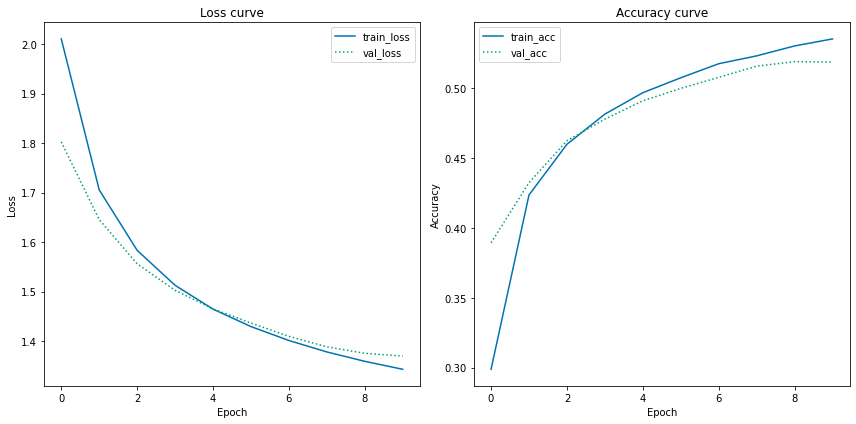

Done! Plots are generated and saved in the output folder as plots_assign_3.png


In [23]:
#generate and save the plots of the loss and accuracy to a specific folder
plot_history(H,10)
plt.savefig(outpath + "/" + "plots_assign_3.png", dpi=300, bbox_inches='tight')
plt.show()

print("Done! Plots are generated and saved in the output folder as plots_assign_3.png")

In [24]:
predictions = model.predict(X_test, batch_size = 128)

report = (classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1), #return the biggest value of the predictions
                            target_names= label_names))
print(report) #print classification report

              precision    recall  f1-score   support

    airplane       0.60      0.55      0.57      1000
  automobile       0.53      0.62      0.57      1000
        bird       0.42      0.40      0.41      1000
         cat       0.36      0.45      0.40      1000
        deer       0.47      0.54      0.51      1000
         dog       0.59      0.36      0.45      1000
        frog       0.63      0.56      0.59      1000
       horse       0.59      0.54      0.56      1000
        ship       0.54      0.72      0.62      1000
       truck       0.55      0.44      0.49      1000

    accuracy                           0.52     10000
   macro avg       0.53      0.52      0.52     10000
weighted avg       0.53      0.52      0.52     10000



In [26]:
#Save the classification report
g = open("../../cds-visual/Assignments/output/classification_assign_3.txt",'w')
print(report, file=g)

print("Done! Report has been generated and saved in the output folder as classification_assign_3.txt")

Done! Report has been generated and saved in the output folder as classification_assign_3.txt
